**16장 – RNN과 어텐션을 사용한 자연어 처리**

_이 노트북에는 16장의 모든 샘플 코드와 연습 문제에 대한 해답이 포함되어 있습니다._

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/rickiepark/handson-ml3/blob/main/16_nlp_with_rnns_and_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

# 설정

이 프로젝트에는 Python 3.7 이상이 필요합니다:

In [1]:
import sys

assert sys.version_info >= (3, 7)

그리고 TensorFlow ≥ 2.8:

In [2]:
from packaging import version
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

이전 챕터에서 했던 것처럼 기본 글꼴 크기를 정의하여 그림을 더 예쁘게 만들어 보겠습니다:

In [3]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

import sys
# 코랩의 경우 나눔 폰트를 설치합니다.
if 'google.colab' in sys.modules:
    !sudo apt-get -qq -y install fonts-nanum
    import matplotlib.font_manager as fm
    font_files = fm.findSystemFonts(fontpaths=['/usr/share/fonts/truetype/nanum'])
    for fpath in font_files:
        fm.fontManager.addfont(fpath)

# 나눔 폰트를 사용합니다.
import matplotlib 

matplotlib.rc('font', family='NanumBarunGothic')
matplotlib.rcParams['axes.unicode_minus'] = False

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 122518 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20180306-3_all.deb ...
Unpacking fonts-nanum (20180306-3) ...
Setting up fonts-nanum (20180306-3) ...
Processing triggers for fontconfig (2.13.1-2ubuntu3) ...


그리고 `images/nlp` 폴더를 만들고(아직 존재하지 않는 경우), 이 노트북을 통해 책에 사용할 그림을 고해상도로 저장하는 데 사용되는 `save_fig()` 함수를 정의해 보겠습니다:

In [4]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "nlp"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

이 챕터는 GPU가 없으면 매우 느려질 수 있으므로 GPU가 있는지 확인하거나 그렇지 않으면 경고를 표시합니다:

In [5]:
if not tf.config.list_physical_devices('GPU'):
    print("GPU가 감지되지 않았습니다. 신경망은 GPU가 없으면 매우 느릴 수 있습니다.")
    if "google.colab" in sys.modules:
        print("런타임 > 런타임 유형 변경으로 이동하여 하드웨어 가속기에서 GPU를 선택합니다.")

# char-RNN을 사용하여 셰익스피어 같은 텍스트 생성하기

## 훈련 데이터셋 생성하기

안드레이 카파시의 [char-rnn 프로젝트](https://github.com/karpathy/char-rnn/)에서 셰익스피어 데이터를 다운로드해 보겠습니다.

In [6]:
import tensorflow as tf

shakespeare_url = "https://homl.info/shakespeare"  # 단축 URL
filepath = tf.keras.utils.get_file("shakespeare.txt", shakespeare_url)
with open(filepath) as f:
    shakespeare_text = f.read()

1115394/1115394 [==============================] - 0s 0us/step


In [7]:
# 추가 코드 - 짧은 텍스트 샘플을 표시합니다.
print(shakespeare_text[:80])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.


In [8]:
# 추가 코드 - 39개의 고유 문자를 모두 표시합니다(소문자로 변환 후).
"".join(sorted(set(shakespeare_text.lower())))

"\n !$&',-.3:;?abcdefghijklmnopqrstuvwxyz"

In [9]:
text_vec_layer = tf.keras.layers.TextVectorization(split="character",
                                                   standardize="lower")
text_vec_layer.adapt([shakespeare_text])
encoded = text_vec_layer([shakespeare_text])[0]

In [10]:
encoded -= 2  # 토큰 0(패딩)과 1(알 수 없음)을 드롭하는데, 이 토큰은 사용하지 않습니다.
n_tokens = text_vec_layer.vocabulary_size() - 2  # 고유 문자 수 = 39
dataset_size = len(encoded)  # 총 문자 수 = 1,115,394

In [11]:
n_tokens

39

In [12]:
dataset_size

1115394

In [13]:
def to_dataset(sequence, length, shuffle=False, seed=None, batch_size=32):
    ds = tf.data.Dataset.from_tensor_slices(sequence)
    ds = ds.window(length + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda window_ds: window_ds.batch(length + 1))
    if shuffle:
        ds = ds.shuffle(100_000, seed=seed)
    ds = ds.batch(batch_size)
    return ds.map(lambda window: (window[:, :-1], window[:, 1:])).prefetch(1)

In [14]:
# 추가 코드 - to_dataset()을 사용하는 간단한 예제
# 이 데이터셋에는 하나의 샘플만 있습니다. 입력은 "to b"이고 출력은 "o be"입니다.
list(to_dataset(text_vec_layer(["To be"])[0], length=4))

[(<tf.Tensor: shape=(1, 4), dtype=int64, numpy=array([[ 4,  5,  2, 23]])>,
  <tf.Tensor: shape=(1, 4), dtype=int64, numpy=array([[ 5,  2, 23,  3]])>)]

In [15]:
length = 100
tf.random.set_seed(42)
train_set = to_dataset(encoded[:1_000_000], length=length, shuffle=True,
                       seed=42)
valid_set = to_dataset(encoded[1_000_000:1_060_000], length=length)
test_set = to_dataset(encoded[1_060_000:], length=length)

## Char-RNN 모델 구축 및 훈련하기

**경고**: 다음 코드는 GPU에 따라 실행하는 데 1~2시간이 걸릴 수 있습니다. GPU가 없는 경우 24시간 이상 걸릴 수 있습니다. 기다리지 않으려면 다음 두 코드 셀을 건너뛰고 아래 코드를 실행하여 사전 학습된 모델을 다운로드하세요.

**참고**: (GPU가 있는 경우) `GRU` 클래스는 다음 매개변수의 기본값을 사용할 때 cuDNN 가속을 사용합니다: `activation`, `recurrent_activation`, `recurrent_dropout`, `unroll`, `use_bias`, `reset_after`.

In [16]:
tf.random.set_seed(42)  # 추가 코드 - CPU에서 재현성 보장
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=n_tokens, output_dim=16),
    tf.keras.layers.GRU(128, return_sequences=True),
    tf.keras.layers.Dense(n_tokens, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
model_ckpt = tf.keras.callbacks.ModelCheckpoint(
    "my_shakespeare_model", monitor="val_accuracy", save_best_only=True)
history = model.fit(train_set, validation_data=valid_set, epochs=10,
                    callbacks=[model_ckpt])

Epoch 1/10
  31244/Unknown - 453s 14ms/step - loss: 1.4083 - accuracy: 0.5696

31247/31247 [==============================] - 478s 14ms/step - loss: 1.4083 - accuracy: 0.5696 - val_loss: 1.6093 - val_accuracy: 0.5296
Epoch 2/10
31247/31247 [==============================] - ETA: 0s - loss: 1.3105 - accuracy: 0.5922

31247/31247 [==============================] - 440s 13ms/step - loss: 1.3105 - accuracy: 0.5922 - val_loss: 1.5852 - val_accuracy: 0.5342
Epoch 3/10
31245/31247 [============================>.] - ETA: 0s - loss: 1.2921 - accuracy: 0.5961

31247/31247 [==============================] - 471s 14ms/step - loss: 1.2921 - accuracy: 0.5961 - val_loss: 1.5798 - val_accuracy: 0.5374
Epoch 4/10
31242/31247 [============================>.] - ETA: 0s - loss: 1.2820 - accuracy: 0.5983

31247/31247 [==============================] - 461s 14ms/step - loss: 1.2820 - accuracy: 0.5983 - val_loss: 1.5721 - val_accuracy: 0.5412
Epoch 5/10
31247/31247 [==============================] - 457s 14ms/step - loss: 1.2751 - accuracy: 0.5998 - val_loss: 1.5796 - val_accuracy: 0.5386
Epoch 6/10
31242/31247 [============================>.] - ETA: 0s - loss: 1.2711 - accuracy: 0.6005

31247/31247 [==============================] - 467s 14ms/step - loss: 1.2711 - accuracy: 0.6005 - val_loss: 1.5732 - val_accuracy: 0.5423
Epoch 7/10
31243/31247 [============================>.] - ETA: 0s - loss: 1.2669 - accuracy: 0.6016

31247/31247 [==============================] - 451s 14ms/step - loss: 1.2669 - accuracy: 0.6016 - val_loss: 1.5669 - val_accuracy: 0.5431
Epoch 8/10
31247/31247 [==============================] - 460s 14ms/step - loss: 1.2646 - accuracy: 0.6019 - val_loss: 1.5721 - val_accuracy: 0.5422
Epoch 9/10
31242/31247 [============================>.] - ETA: 0s - loss: 1.2616 - accuracy: 0.6025

31247/31247 [==============================] - 456s 14ms/step - loss: 1.2616 - accuracy: 0.6025 - val_loss: 1.5698 - val_accuracy: 0.5454
Epoch 10/10
31247/31247 [==============================] - 454s 14ms/step - loss: 1.2620 - accuracy: 0.6026 - val_loss: 1.5659 - val_accuracy: 0.5430


In [17]:
shakespeare_model = tf.keras.Sequential([
    text_vec_layer,
    tf.keras.layers.Lambda(lambda X: X - 2),  # <PAD>나 <UNK> 토큰 없음
    model
])

훈련이 완료될 때까지 기다리기 싫으시다면 모델을 미리 훈련해 두었습니다. 다음 코드에서 다운로드할 수 있습니다. 위에서 학습된 모델 대신 이 모델을 사용하려면 마지막 줄의 주석 처리를 해제하세요.

In [18]:
# 추가 코드 - 사전 훈련된 모델 다운로드
url = "https://github.com/ageron/data/raw/main/shakespeare_model.tgz"
path = tf.keras.utils.get_file("shakespeare_model.tgz", url, extract=True)
model_path = Path(path).with_name("shakespeare_model")
shakespeare_model = tf.keras.models.load_model(model_path)

352865/352865 [==============================] - 0s 0us/step


In [19]:
y_proba = shakespeare_model.predict(["To be or not to b"])[0, -1]
y_pred = tf.argmax(y_proba)  # 가장 가능성이 높은 문자 ID 선택
text_vec_layer.get_vocabulary()[y_pred + 2]

1/1 [==============================] - 0s 448ms/step


'e'

## 가짜 셰익스피어 텍스트 생성하기

In [20]:
log_probas = tf.math.log([[0.5, 0.4, 0.1]])  # 확률 = 50%, 40%, 10%
tf.random.set_seed(42)
tf.random.categorical(log_probas, num_samples=8)  # 샘플 8개를 뽑습니다.

<tf.Tensor: shape=(1, 8), dtype=int64, numpy=array([[0, 0, 1, 1, 1, 0, 0, 0]])>

In [21]:
def next_char(text, temperature=1):
    y_proba = shakespeare_model.predict([text])[0, -1:]
    rescaled_logits = tf.math.log(y_proba) / temperature
    char_id = tf.random.categorical(rescaled_logits, num_samples=1)[0, 0]
    return text_vec_layer.get_vocabulary()[char_id + 2]

In [22]:
def extend_text(text, n_chars=50, temperature=1):
    for _ in range(n_chars):
        text += next_char(text, temperature)
    return text

In [23]:
tf.random.set_seed(42)  # 추가 코드 - CPU에서 재현성 보장

In [24]:
print(extend_text("To be or not to be", temperature=0.01))

1/1 [==============================] - 0s 39ms/step
To be or not to be the duke
as it is a proper strange death,
and the


In [25]:
print(extend_text("To be or not to be", temperature=1))

1/1 [==============================] - 0s 40ms/step
To be or not to begg, i
point and through you are to-morrow?

romeo:


In [26]:
print(extend_text("To be or not to be", temperature=100))

1/1 [==============================] - 0s 37ms/step
To be or not to bepevicm-vilv!?$mz?gmjz :3?ljb'va;!td&
i.ur3l'-j!3em


## 상태가 있는 RNN

In [27]:
def to_dataset_for_stateful_rnn(sequence, length):
    ds = tf.data.Dataset.from_tensor_slices(sequence)
    ds = ds.window(length + 1, shift=length, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(length + 1)).batch(1)
    return ds.map(lambda window: (window[:, :-1], window[:, 1:])).prefetch(1)

stateful_train_set = to_dataset_for_stateful_rnn(encoded[:1_000_000], length)
stateful_valid_set = to_dataset_for_stateful_rnn(encoded[1_000_000:1_060_000],
                                                 length)
stateful_test_set = to_dataset_for_stateful_rnn(encoded[1_060_000:], length)

In [28]:
# 추가 코드 - to_dataset_for_stateful_rnn()을 사용한 간단한 예제
list(to_dataset_for_stateful_rnn(tf.range(10), 3))

[(<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[0, 1, 2]], dtype=int32)>,
  <tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[1, 2, 3]], dtype=int32)>),
 (<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[3, 4, 5]], dtype=int32)>,
  <tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[4, 5, 6]], dtype=int32)>),
 (<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[6, 7, 8]], dtype=int32)>,
  <tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[7, 8, 9]], dtype=int32)>)]

배치당 두 개 이상의 윈도가 있다면 `to_dataset_for_stateful_rnn()` 대신 `to_batched_dataset_for_stateful_rnn()` 함수를 사용할 수 있습니다:

In [29]:
# 추가 코드 - 상태가 있는 RNN을 위해 배치 데이터셋을 준비하는 한 가지 방법을 보여줍니다.

import numpy as np

def to_non_overlapping_windows(sequence, length):
    ds = tf.data.Dataset.from_tensor_slices(sequence)
    ds = ds.window(length + 1, shift=length, drop_remainder=True)
    return ds.flat_map(lambda window: window.batch(length + 1))

def to_batched_dataset_for_stateful_rnn(sequence, length, batch_size=32):
    parts = np.array_split(sequence, batch_size)
    datasets = tuple(to_non_overlapping_windows(part, length) for part in parts)
    ds = tf.data.Dataset.zip(datasets).map(lambda *windows: tf.stack(windows))
    return ds.map(lambda window: (window[:, :-1], window[:, 1:])).prefetch(1)

list(to_batched_dataset_for_stateful_rnn(tf.range(20), length=3, batch_size=2))

[(<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[ 0,  1,  2],
         [10, 11, 12]], dtype=int32)>,
  <tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[ 1,  2,  3],
         [11, 12, 13]], dtype=int32)>),
 (<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[ 3,  4,  5],
         [13, 14, 15]], dtype=int32)>,
  <tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[ 4,  5,  6],
         [14, 15, 16]], dtype=int32)>),
 (<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[ 6,  7,  8],
         [16, 17, 18]], dtype=int32)>,
  <tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[ 7,  8,  9],
         [17, 18, 19]], dtype=int32)>)]

In [30]:
tf.random.set_seed(42)  # 추가 코드 - CPU에서 재현성 보장
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=n_tokens, output_dim=16,
                              batch_input_shape=[1, None]),
    tf.keras.layers.GRU(128, return_sequences=True, stateful=True),
    tf.keras.layers.Dense(n_tokens, activation="softmax")
])

In [31]:
class ResetStatesCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

In [32]:
# 추가 코드 - 다른 디렉터리를 사용하여 체크포인트를 저장합니다.
model_ckpt = tf.keras.callbacks.ModelCheckpoint(
    "my_stateful_shakespeare_model",
    monitor="val_accuracy",
    save_best_only=True)

**경고**: 다음 셀을 실행하는 데 시간이 걸릴 수 있습니다(GPU를 사용하지 않는 경우 1시간 정도 소요될 수 있음).

In [33]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(stateful_train_set, validation_data=stateful_valid_set,
                    epochs=10, callbacks=[ResetStatesCallback(), model_ckpt])

Epoch 1/10
   9999/Unknown - 90s 9ms/step - loss: 1.8903 - accuracy: 0.4442

9999/9999 [==============================] - 96s 9ms/step - loss: 1.8903 - accuracy: 0.4442 - val_loss: 1.7161 - val_accuracy: 0.4859
Epoch 2/10
9999/9999 [==============================] - ETA: 0s - loss: 1.5704 - accuracy: 0.5262

9999/9999 [==============================] - 96s 10ms/step - loss: 1.5704 - accuracy: 0.5262 - val_loss: 1.6189 - val_accuracy: 0.5150
Epoch 3/10
9997/9999 [============================>.] - ETA: 0s - loss: 1.4856 - accuracy: 0.5485

9999/9999 [==============================] - 94s 9ms/step - loss: 1.4856 - accuracy: 0.5485 - val_loss: 1.5805 - val_accuracy: 0.5291
Epoch 4/10
9997/9999 [============================>.] - ETA: 0s - loss: 1.4455 - accuracy: 0.5584

9999/9999 [==============================] - 94s 9ms/step - loss: 1.4455 - accuracy: 0.5584 - val_loss: 1.5584 - val_accuracy: 0.5339
Epoch 5/10
9993/9999 [============================>.] - ETA: 0s - loss: 1.4210 - accuracy: 0.5646

9999/9999 [==============================] - 95s 9ms/step - loss: 1.4210 - accuracy: 0.5646 - val_loss: 1.5520 - val_accuracy: 0.5367
Epoch 6/10
9993/9999 [============================>.] - ETA: 0s - loss: 1.4046 - accuracy: 0.5687

9999/9999 [==============================] - 94s 9ms/step - loss: 1.4046 - accuracy: 0.5688 - val_loss: 1.5477 - val_accuracy: 0.5381
Epoch 7/10
9993/9999 [============================>.] - ETA: 0s - loss: 1.3929 - accuracy: 0.5717

9999/9999 [==============================] - 94s 9ms/step - loss: 1.3928 - accuracy: 0.5717 - val_loss: 1.5415 - val_accuracy: 0.5408
Epoch 8/10
9994/9999 [============================>.] - ETA: 0s - loss: 1.3842 - accuracy: 0.5742

9999/9999 [==============================] - 97s 10ms/step - loss: 1.3842 - accuracy: 0.5742 - val_loss: 1.5374 - val_accuracy: 0.5409
Epoch 9/10
9993/9999 [============================>.] - ETA: 0s - loss: 1.3777 - accuracy: 0.5755

9999/9999 [==============================] - 95s 10ms/step - loss: 1.3776 - accuracy: 0.5756 - val_loss: 1.5335 - val_accuracy: 0.5414
Epoch 10/10
9996/9999 [============================>.] - ETA: 0s - loss: 1.3726 - accuracy: 0.5768

9999/9999 [==============================] - 93s 9ms/step - loss: 1.3725 - accuracy: 0.5768 - val_loss: 1.5277 - val_accuracy: 0.5419


**추가 자료: 상태가 있는 RNN을 상태가 없는 RNN으로 변환하여 사용하기**

다른 배치 크기로 모델을 사용하려면 상태가 없는 모델 복사본을 만들어야 합니다:

In [34]:
stateless_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=n_tokens, output_dim=16),
    tf.keras.layers.GRU(128, return_sequences=True),
    tf.keras.layers.Dense(n_tokens, activation="softmax")
])

가중치를 설정하려면 먼저 모델을 빌드해야 합니다(가중치가 생성되도록):

In [35]:
stateless_model.build(tf.TensorShape([None, None]))

In [36]:
stateless_model.set_weights(model.get_weights())

In [37]:
shakespeare_model = tf.keras.Sequential([
    text_vec_layer,
    tf.keras.layers.Lambda(lambda X: X - 2),  # <PAD>나 <UNK> 토큰 없음
    stateless_model
])

In [38]:
tf.random.set_seed(42)

print(extend_text("to be or not to be", temperature=0.01))

1/1 [==============================] - 0s 52ms/step
to be or not to be so
have the will be so have the will be so have t


# 감성 분석

In [39]:
import tensorflow_datasets as tfds

raw_train_set, raw_valid_set, raw_test_set = tfds.load(
    name="imdb_reviews",
    split=["train[:90%]", "train[90%:]", "test"],
    as_supervised=True
)
tf.random.set_seed(42)
train_set = raw_train_set.shuffle(5000, seed=42).batch(32).prefetch(1)
valid_set = raw_valid_set.batch(32).prefetch(1)
test_set = raw_test_set.batch(32).prefetch(1)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteNRMR3Z/imdb_reviews-train.tfrecord…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteNRMR3Z/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteNRMR3Z/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [40]:
for review, label in raw_train_set.take(4):
    print(review.numpy().decode("utf-8")[:200], "...")
    print("레이블:", label.numpy())

This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting  ...
레이블: 0
I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However  ...
레이블: 0
Mann photographs the Alberta Rocky Mountains in a superb fashion, and Jimmy Stewart and Walter Brennan give enjoyable performances as they always seem to do. <br /><br />But come on Hollywood - a Moun ...
레이블: 0
This is the kind of film for a snowy Sunday afternoon when the rest of the world can go ahead with its own business as you descend into a big arm-chair and mellow for a couple of hours. Wonderful perf ...
레이블: 1


In [41]:
vocab_size = 1000
text_vec_layer = tf.keras.layers.TextVectorization(max_tokens=vocab_size)
text_vec_layer.adapt(train_set.map(lambda reviews, labels: reviews))

**경고**: 다음 셀은 실행하는 데 몇 분 정도 걸리며 패딩 토큰을 마스킹하지 않았기 때문에 모델이 아무것도 학습하지 못할 수 있습니다(다음 섹션의 요점입니다).

In [42]:
embed_size = 128
tf.random.set_seed(42)
model = tf.keras.Sequential([
    text_vec_layer,
    tf.keras.layers.Embedding(vocab_size, embed_size),
    tf.keras.layers.GRU(128),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=2)

Epoch 1/2
704/704 [==============================] - 65s 88ms/step - loss: 0.6934 - accuracy: 0.5001 - val_loss: 0.6931 - val_accuracy: 0.5012
Epoch 2/2
704/704 [==============================] - 28s 40ms/step - loss: 0.6929 - accuracy: 0.5051 - val_loss: 0.6936 - val_accuracy: 0.4992


## 마스킹

**경고**: 다음 셀을 실행하는 데 시간이 걸립니다(GPU를 사용하지 않는 경우 30분 정도 소요될 수 있습니다).

In [43]:
embed_size = 128
tf.random.set_seed(42)
model = tf.keras.Sequential([
    text_vec_layer,
    tf.keras.layers.Embedding(vocab_size, embed_size, mask_zero=True),
    tf.keras.layers.GRU(128),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=5)

Epoch 1/5
704/704 [==============================] - 61s 77ms/step - loss: 0.5274 - accuracy: 0.7255 - val_loss: 0.3541 - val_accuracy: 0.8448
Epoch 2/5
704/704 [==============================] - 32s 45ms/step - loss: 0.3263 - accuracy: 0.8612 - val_loss: 0.3243 - val_accuracy: 0.8588
Epoch 3/5
704/704 [==============================] - 29s 41ms/step - loss: 0.2880 - accuracy: 0.8782 - val_loss: 0.2974 - val_accuracy: 0.8740
Epoch 4/5
704/704 [==============================] - 28s 40ms/step - loss: 0.2677 - accuracy: 0.8888 - val_loss: 0.3018 - val_accuracy: 0.8696
Epoch 5/5
704/704 [==============================] - 28s 39ms/step - loss: 0.2547 - accuracy: 0.8964 - val_loss: 0.3106 - val_accuracy: 0.8608


또는 수동 마스킹을 사용합니다:

In [44]:
tf.random.set_seed(42)  # 추가 코드 - CPU에서 재현성 보장
inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)
token_ids = text_vec_layer(inputs)
mask = tf.math.not_equal(token_ids, 0)
Z = tf.keras.layers.Embedding(vocab_size, embed_size)(token_ids)
Z = tf.keras.layers.GRU(128, dropout=0.2)(Z, mask=mask)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(Z)
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

**경고**: 다음 셀을 실행하는 데 시간이 걸립니다(GPU를 사용하지 않는 경우 30분 정도 소요될 수 있습니다).

In [45]:
# 추가 코드 - 평소와 같이 모델을 컴파일하고 훈련합니다.
model.compile(loss="binary_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=5)

Epoch 1/5
704/704 [==============================] - 62s 81ms/step - loss: 0.4778 - accuracy: 0.7717 - val_loss: 0.3933 - val_accuracy: 0.8336
Epoch 2/5
704/704 [==============================] - 31s 43ms/step - loss: 0.3391 - accuracy: 0.8588 - val_loss: 0.3140 - val_accuracy: 0.8736
Epoch 3/5
704/704 [==============================] - 28s 40ms/step - loss: 0.2920 - accuracy: 0.8803 - val_loss: 0.3230 - val_accuracy: 0.8628
Epoch 4/5
704/704 [==============================] - 29s 41ms/step - loss: 0.2717 - accuracy: 0.8897 - val_loss: 0.3121 - val_accuracy: 0.8668
Epoch 5/5
704/704 [==============================] - 28s 40ms/step - loss: 0.2548 - accuracy: 0.8976 - val_loss: 0.3218 - val_accuracy: 0.8668


**추가 자료: 래그드 텐서 사용하기**

In [46]:
text_vec_layer_ragged = tf.keras.layers.TextVectorization(
    max_tokens=vocab_size, ragged=True)
text_vec_layer_ragged.adapt(train_set.map(lambda reviews, labels: reviews))
text_vec_layer_ragged(["Great movie!", "This is DiCaprio's best role."])

<tf.RaggedTensor [[86, 18], [11, 7, 1, 116, 217]]>

In [47]:
text_vec_layer(["Great movie!", "This is DiCaprio's best role."])

<tf.Tensor: shape=(2, 5), dtype=int64, numpy=
array([[ 86,  18,   0,   0,   0],
       [ 11,   7,   1, 116, 217]])>

**경고**: 다음 셀을 실행하는 데 시간이 걸립니다(GPU를 사용하지 않는 경우 30분 정도 소요될 수 있습니다).

In [48]:
embed_size = 128
tf.random.set_seed(42)
model = tf.keras.Sequential([
    text_vec_layer_ragged,
    tf.keras.layers.Embedding(vocab_size, embed_size),
    tf.keras.layers.GRU(128),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=5)

Epoch 1/5
704/704 [==============================] - 61s 81ms/step - loss: 0.4700 - accuracy: 0.7751 - val_loss: 0.3720 - val_accuracy: 0.8416
Epoch 2/5
704/704 [==============================] - 33s 47ms/step - loss: 0.3254 - accuracy: 0.8623 - val_loss: 0.3254 - val_accuracy: 0.8632
Epoch 3/5
704/704 [==============================] - 30s 43ms/step - loss: 0.2940 - accuracy: 0.8782 - val_loss: 0.3091 - val_accuracy: 0.8656
Epoch 4/5
704/704 [==============================] - 30s 43ms/step - loss: 0.2648 - accuracy: 0.8935 - val_loss: 0.3181 - val_accuracy: 0.8672
Epoch 5/5
704/704 [==============================] - 29s 42ms/step - loss: 0.2497 - accuracy: 0.8987 - val_loss: 0.3505 - val_accuracy: 0.8636


## 사전 훈련된 임베딩 및 언어 모델 재사용하기

**경고**: 다음 셀을 실행하는 데 시간이 걸릴 수 있습니다(GPU를 사용하지 않는 경우 1시간 정도 소요될 수 있음).

In [49]:
import os
import tensorflow_hub as hub

os.environ["TFHUB_CACHE_DIR"] = "my_tfhub_cache"
tf.random.set_seed(42)  # 추가 코드 - CPU에서 재현성 보장
model = tf.keras.Sequential([
    # trainable=True로 할 경우 코랩에서 메모리 부족 에러가 발생합니다.
    hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                   trainable=False, dtype=tf.string, input_shape=[]),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
model.fit(train_set, validation_data=valid_set, epochs=10)

Epoch 1/10
704/704 [==============================] - 38s 47ms/step - loss: 0.3812 - accuracy: 0.8393 - val_loss: 0.3328 - val_accuracy: 0.8508
Epoch 2/10
704/704 [==============================] - 32s 45ms/step - loss: 0.3251 - accuracy: 0.8608 - val_loss: 0.3228 - val_accuracy: 0.8516
Epoch 3/10
704/704 [==============================] - 33s 47ms/step - loss: 0.3207 - accuracy: 0.8639 - val_loss: 0.3228 - val_accuracy: 0.8520
Epoch 4/10
704/704 [==============================] - 32s 45ms/step - loss: 0.3160 - accuracy: 0.8665 - val_loss: 0.3207 - val_accuracy: 0.8548
Epoch 5/10
704/704 [==============================] - 33s 47ms/step - loss: 0.3119 - accuracy: 0.8686 - val_loss: 0.3191 - val_accuracy: 0.8560
Epoch 6/10
704/704 [==============================] - 32s 45ms/step - loss: 0.3080 - accuracy: 0.8696 - val_loss: 0.3159 - val_accuracy: 0.8576
Epoch 7/10
704/704 [==============================] - 34s 49ms/step - loss: 0.3031 - accuracy: 0.8708 - val_loss: 0.3285 - val_accuracy:

# 신경망 기계 번역을 위한 인코더-디코더 네트워크

In [50]:
url = "https://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip"
path = tf.keras.utils.get_file("spa-eng.zip", origin=url, cache_dir="datasets",
                               extract=True)
text = (Path(path).with_name("spa-eng") / "spa.txt").read_text()

2638744/2638744 [==============================] - 1s 0us/step


In [51]:
import numpy as np

text = text.replace("¡", "").replace("¿", "")
pairs = [line.split("\t") for line in text.splitlines()]
np.random.seed(42)  # 추가 코드 - CPU에서 재현성 보장
np.random.shuffle(pairs)
sentences_en, sentences_es = zip(*pairs)  # 쌍을 2개의 리스트로 분리합니다.

In [52]:
for i in range(3):
    print(sentences_en[i], "=>", sentences_es[i])

How boring! => Qué aburrimiento!
I love sports. => Adoro el deporte.
Would you like to swap jobs? => Te gustaría que intercambiemos los trabajos?


In [53]:
vocab_size = 1000
max_length = 50
text_vec_layer_en = tf.keras.layers.TextVectorization(
    vocab_size, output_sequence_length=max_length)
text_vec_layer_es = tf.keras.layers.TextVectorization(
    vocab_size, output_sequence_length=max_length)
text_vec_layer_en.adapt(sentences_en)
text_vec_layer_es.adapt([f"startofseq {s} endofseq" for s in sentences_es])

In [54]:
text_vec_layer_en.get_vocabulary()[:10]

['', '[UNK]', 'the', 'i', 'to', 'you', 'tom', 'a', 'is', 'he']

In [55]:
text_vec_layer_es.get_vocabulary()[:10]

['', '[UNK]', 'startofseq', 'endofseq', 'de', 'que', 'a', 'no', 'tom', 'la']

In [56]:
X_train = tf.constant(sentences_en[:100_000])
X_valid = tf.constant(sentences_en[100_000:])
X_train_dec = tf.constant([f"startofseq {s}" for s in sentences_es[:100_000]])
X_valid_dec = tf.constant([f"startofseq {s}" for s in sentences_es[100_000:]])
Y_train = text_vec_layer_es([f"{s} endofseq" for s in sentences_es[:100_000]])
Y_valid = text_vec_layer_es([f"{s} endofseq" for s in sentences_es[100_000:]])

In [57]:
tf.random.set_seed(42)  # 추가 코드 - CPU에서 재현성 보장
encoder_inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)
decoder_inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)

In [58]:
embed_size = 128
encoder_input_ids = text_vec_layer_en(encoder_inputs)
decoder_input_ids = text_vec_layer_es(decoder_inputs)
encoder_embedding_layer = tf.keras.layers.Embedding(vocab_size, embed_size,
                                                    mask_zero=True)
decoder_embedding_layer = tf.keras.layers.Embedding(vocab_size, embed_size,
                                                    mask_zero=True)
encoder_embeddings = encoder_embedding_layer(encoder_input_ids)
decoder_embeddings = decoder_embedding_layer(decoder_input_ids)

In [59]:
encoder = tf.keras.layers.LSTM(512, return_state=True)
encoder_outputs, *encoder_state = encoder(encoder_embeddings)

In [60]:
decoder = tf.keras.layers.LSTM(512, return_sequences=True)
decoder_outputs = decoder(decoder_embeddings, initial_state=encoder_state)

In [61]:
output_layer = tf.keras.layers.Dense(vocab_size, activation="softmax")
Y_proba = output_layer(decoder_outputs)

**경고**: 다음 셀을 실행하는 데 시간이 걸릴 수 있습니다(GPU를 사용하지 않는 경우 몇 시간이 걸릴 수 있습니다).

In [62]:
model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs],
                       outputs=[Y_proba])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
model.fit((X_train, X_train_dec), Y_train, epochs=10,
          validation_data=((X_valid, X_valid_dec), Y_valid))

Epoch 1/10
3125/3125 [==============================] - 122s 36ms/step - loss: 2.9134 - accuracy: 0.4284 - val_loss: 2.1610 - val_accuracy: 0.5258
Epoch 2/10
3125/3125 [==============================] - 81s 26ms/step - loss: 1.8394 - accuracy: 0.5767 - val_loss: 1.6493 - val_accuracy: 0.6116
Epoch 3/10
3125/3125 [==============================] - 85s 27ms/step - loss: 1.4269 - accuracy: 0.6509 - val_loss: 1.4209 - val_accuracy: 0.6552
Epoch 4/10
3125/3125 [==============================] - 80s 26ms/step - loss: 1.1942 - accuracy: 0.6966 - val_loss: 1.3315 - val_accuracy: 0.6733
Epoch 5/10
3125/3125 [==============================] - 78s 25ms/step - loss: 1.0315 - accuracy: 0.7301 - val_loss: 1.2893 - val_accuracy: 0.6836
Epoch 6/10
3125/3125 [==============================] - 78s 25ms/step - loss: 0.8994 - accuracy: 0.7586 - val_loss: 1.2818 - val_accuracy: 0.6863
Epoch 7/10
3125/3125 [==============================] - 80s 26ms/step - loss: 0.7863 - accuracy: 0.7828 - val_loss: 1.2974 

In [63]:
def translate(sentence_en):
    translation = ""
    for word_idx in range(max_length):
        X = np.array([sentence_en])  # encoder input 
        X_dec = np.array(["startofseq " + translation])  # decoder input
        y_proba = model.predict((X, X_dec))[0, word_idx]  # last token's probas
        predicted_word_id = np.argmax(y_proba)
        predicted_word = text_vec_layer_es.get_vocabulary()[predicted_word_id]
        if predicted_word == "endofseq":
            break
        translation += " " + predicted_word
    return translation.strip()

In [64]:
translate("I like soccer")

1/1 [==============================] - 0s 31ms/step


'me gusta el fútbol'

멋지네요! 그러나 이 모델은 긴 문장을 처리하는 데 어려움을 겪습니다:

In [65]:
translate("I like soccer and also going to the beach")

1/1 [==============================] - 0s 38ms/step


'me gusta la [UNK] y [UNK] como los domingos'

## 양방향 RNN

양방향 순환 층을 만들려면 일반 순환 층을 `Bidirectional` 층으로 감싸면 됩니다:

In [66]:
tf.random.set_seed(42)  # 추가 코드 - CPU에서 재현성 보장
encoder = tf.keras.layers.Bidirectional(
    tf.keras.layers.LSTM(256, return_state=True))

In [67]:
encoder_outputs, *encoder_state = encoder(encoder_embeddings)
encoder_state = [tf.concat(encoder_state[::2], axis=-1),  # 단기 상태 (0 & 2)
                 tf.concat(encoder_state[1::2], axis=-1)]  # 장기 상태 (1 & 3)

**경고**: 다음 셀을 실행하는 데 시간이 걸릴 수 있습니다(GPU를 사용하지 않는 경우 몇 시간이 걸릴 수 있습니다).

In [68]:
# 추가 코드 - 모델을 완성하고 학습시킵니다.
decoder = tf.keras.layers.LSTM(512, return_sequences=True)
decoder_outputs = decoder(decoder_embeddings, initial_state=encoder_state)
output_layer = tf.keras.layers.Dense(vocab_size, activation="softmax")
Y_proba = output_layer(decoder_outputs)
model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs],
                       outputs=[Y_proba])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
model.fit((X_train, X_train_dec), Y_train, epochs=10,
          validation_data=((X_valid, X_valid_dec), Y_valid))

Epoch 1/10
3125/3125 [==============================] - 152s 44ms/step - loss: 2.0742 - accuracy: 0.5544 - val_loss: 1.4790 - val_accuracy: 0.6438
Epoch 2/10
3125/3125 [==============================] - 111s 35ms/step - loss: 1.2850 - accuracy: 0.6812 - val_loss: 1.2740 - val_accuracy: 0.6826
Epoch 3/10
3125/3125 [==============================] - 109s 35ms/step - loss: 1.0723 - accuracy: 0.7217 - val_loss: 1.1966 - val_accuracy: 0.7001
Epoch 4/10
3125/3125 [==============================] - 107s 34ms/step - loss: 0.9283 - accuracy: 0.7522 - val_loss: 1.1794 - val_accuracy: 0.7038
Epoch 5/10
3125/3125 [==============================] - 103s 33ms/step - loss: 0.8088 - accuracy: 0.7784 - val_loss: 1.1780 - val_accuracy: 0.7063
Epoch 6/10
3125/3125 [==============================] - 107s 34ms/step - loss: 0.7075 - accuracy: 0.8009 - val_loss: 1.2041 - val_accuracy: 0.7032
Epoch 7/10
3125/3125 [==============================] - 104s 33ms/step - loss: 0.6200 - accuracy: 0.8223 - val_loss: 1

In [69]:
translate("I like soccer")

1/1 [==============================] - 0s 39ms/step


'me gusta el fútbol'

## 빔 검색

이것은 빔 검색의 매우 기본적인 구현입니다. 읽기 쉽고 이해하기 쉽게 만들려고 노력했지만 속도에 최적화되지는 않았습니다! 이 함수는 먼저 모델을 사용하여 번역을 시작하기 위해 상위 _k_ 단어를 찾습니다(여기서 _k_는 빔 너비). 상위 _k_ 번역 각각에 대해 해당 번역에 추가할 수 있는 모든 가능한 단어의 조건부 확률을 평가합니다. 이러한 확장 번역과 해당 확률이 후보 목록에 추가됩니다. 모든 상위 _k_ 번역과 번역을 완성할 수 있는 모든 단어를 검토한 후에는 확률이 가장 높은 상위 _k_ 후보만 유지하고 모든 번역이 EOS 토큰으로 완료될 때까지 반복해서 반복합니다. 그런 다음 상위 번역이 반환됩니다(해당 EOS 토큰을 제거한 후).

* 참고: p(S)가 문장 S의 확률이고 p(W|S)가 번역이 S로 시작한다는 가정 하에 단어 W의 조건부 확률인 경우, 문장 S' = concat(S, W)의 확률은 p(S') = p(S) * p(W|S)입니다. 단어를 더 추가할수록 확률은 점점 더 작아집니다. 너무 작아져 부동 소수점 정밀도 오류가 발생할 수 있는 위험을 피하기 위해 이 함수는 확률 대신 로그 확률을 추적합니다. log(a\*b) = log(a) + log(b), 따라서 log(p(S')) = log(p(S)) + log(p(W|S)).

In [70]:
# 추가 코드 - 빔 검색의 기본 구현

def beam_search(sentence_en, beam_width, verbose=False):
    X = np.array([sentence_en])  # 인코더 입력
    X_dec = np.array(["startofseq"])  # 디코더 입력
    y_proba = model.predict((X, X_dec))[0, 0]  # 첫 번째 토큰의 확률
    top_k = tf.math.top_k(y_proba, k=beam_width)
    top_translations = [  # 촤상의 (log_proba, translation) 리스트 
        (np.log(word_proba), text_vec_layer_es.get_vocabulary()[word_id])
        for word_proba, word_id in zip(top_k.values, top_k.indices)
    ]
    
    # 추가 코드 - verbose 모드에서 상위 첫 단어를 표시합니다.
    if verbose:
        print("상위 첫 단어:", top_translations)

    for idx in range(1, max_length):
        candidates = []
        for log_proba, translation in top_translations:
            if translation.endswith("endofseq"):
                candidates.append((log_proba, translation))
                continue  # 번역이 완료되었으므로 번역을 이어가지 않습니다.
            X = np.array([sentence_en])  # 인코더 입력
            X_dec = np.array(["startofseq " + translation])  # 디코더 입력
            y_proba = model.predict((X, X_dec))[0, idx]  # 마지막 토큰의 확률
            for word_id, word_proba in enumerate(y_proba):
                word = text_vec_layer_es.get_vocabulary()[word_id]
                candidates.append((log_proba + np.log(word_proba),
                                   f"{translation} {word}"))
        top_translations = sorted(candidates, reverse=True)[:beam_width]

        # 추가 코드 - verbose 모드의 경우 지금까지의 최상의 번역을 출력합니다.
        if verbose:
            print("지금까지 최상의 번역:", top_translations)

        if all([tr.endswith("endofseq") for _, tr in top_translations]):
            return top_translations[0][1].replace("endofseq", "").strip()

In [71]:
# 추가 코드 - 모델이 어떻게 오류를 발생시키는지 보여줍니다.
sentence_en = "I love cats and dogs"
translate(sentence_en)

1/1 [==============================] - 0s 39ms/step


'me [UNK] los gatos y los perros'

In [72]:
# 추가 코드 - 빔 검색이 어떻게 도움이 되는지 보여줍니다.
beam_search(sentence_en, beam_width=3, verbose=True)

1/1 [==============================] - 0s 40ms/step
상위 첫 단어: [(-0.081242576, 'me'), (-3.3500824, 'odio'), (-3.5662193, 'yo')]
1/1 [==============================] - 0s 26ms/step
지금까지 최상의 번역: [(-0.79621536, 'me [UNK]'), (-1.42585, 'me gustan'), (-1.9397042, 'me encanta')]
1/1 [==============================] - 0s 41ms/step
지금까지 최상의 번역: [(-0.86510205, 'me [UNK] los'), (-1.4312103, 'me gustan los'), (-2.4591732, 'me encanta los')]
1/1 [==============================] - 0s 25ms/step
지금까지 최상의 번역: [(-1.2447193, 'me [UNK] los gatos'), (-2.0246096, 'me [UNK] los perros'), (-2.1221235, 'me gustan los perros')]
1/1 [==============================] - 0s 29ms/step
지금까지 최상의 번역: [(-1.2883906, 'me [UNK] los gatos y'), (-2.1663733, 'me gustan los perros y'), (-2.2151074, 'me [UNK] los perros y')]
1/1 [==============================] - 0s 30ms/step
지금까지 최상의 번역: [(-1.3628391, 'me [UNK] los gatos y los'), (-2.1718218, 'me gustan los perros y los'), (-2.2216043, 'me [UNK] los perros y los')]
1/1 [========

'me [UNK] los gatos y los perros'

빔 검색에서 찾은 상위 3개 문장에 올바른 번역이 있지만 첫 번째 번역은 아닙니다. 작은 어휘를 사용하기 때문에 \[UNK] 토큰이 꽤 자주 사용되므로 페널티를 줄 수 있습니다(예를 들어, 빔 검색 함수에서 이 토큰의 확률을 2로 나눕니다.): 이렇게 하면 빔 검색이 이 토큰을 너무 많이 사용하지 않게 됩니다.

# 어텐션 메커니즘

모든 인코더의 출력을 `Attention` 층에 공급해야 하므로 인코더에 `return_sequences=True`를 추가해야 합니다:

In [73]:
tf.random.set_seed(42)  # 추가 코드 - CPU에서 재현성 보장
encoder = tf.keras.layers.Bidirectional(
    tf.keras.layers.LSTM(256, return_sequences=True, return_state=True))

In [74]:
# 추가 코드 - 모델의 이 부분은 이전과 완전히 동일합니다.
encoder_outputs, *encoder_state = encoder(encoder_embeddings)
encoder_state = [tf.concat(encoder_state[::2], axis=-1),  # 단기 (0 & 2)
                 tf.concat(encoder_state[1::2], axis=-1)]  # 장기 (1 & 3)
decoder = tf.keras.layers.LSTM(512, return_sequences=True)
decoder_outputs = decoder(decoder_embeddings, initial_state=encoder_state)

마지막으로 'Attention' 층과 출력 층을 추가해 보겠습니다:

In [75]:
attention_layer = tf.keras.layers.Attention()
attention_outputs = attention_layer([decoder_outputs, encoder_outputs])
output_layer = tf.keras.layers.Dense(vocab_size, activation="softmax")
Y_proba = output_layer(attention_outputs)

**경고**: 다음 셀을 실행하는 데 시간이 걸릴 수 있습니다(GPU를 사용하지 않는 경우 몇 시간이 걸릴 수 있습니다).

In [76]:
model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs],
                       outputs=[Y_proba])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
model.fit((X_train, X_train_dec), Y_train, epochs=10,
          validation_data=((X_valid, X_valid_dec), Y_valid))

Epoch 1/10
3125/3125 [==============================] - 145s 42ms/step - loss: 2.0050 - accuracy: 0.5656 - val_loss: 1.4373 - val_accuracy: 0.6527
Epoch 2/10
3125/3125 [==============================] - 109s 35ms/step - loss: 1.2995 - accuracy: 0.6808 - val_loss: 1.2947 - val_accuracy: 0.6847
Epoch 3/10
3125/3125 [==============================] - 108s 35ms/step - loss: 1.1325 - accuracy: 0.7156 - val_loss: 1.2282 - val_accuracy: 0.7002
Epoch 4/10
3125/3125 [==============================] - 110s 35ms/step - loss: 1.0151 - accuracy: 0.7402 - val_loss: 1.2098 - val_accuracy: 0.7082
Epoch 5/10
3125/3125 [==============================] - 105s 33ms/step - loss: 0.9227 - accuracy: 0.7591 - val_loss: 1.2087 - val_accuracy: 0.7080
Epoch 6/10
3125/3125 [==============================] - 104s 33ms/step - loss: 0.8454 - accuracy: 0.7756 - val_loss: 1.2267 - val_accuracy: 0.7098
Epoch 7/10
3125/3125 [==============================] - 106s 34ms/step - loss: 0.7786 - accuracy: 0.7901 - val_loss: 1

In [77]:
translate("I like soccer and also going to the beach")

1/1 [==============================] - 0s 28ms/step


'me gusta el fútbol también también a la playa'

In [78]:
beam_search("I like soccer and also going to the beach", beam_width=3,
            verbose=True)

1/1 [==============================] - 0s 29ms/step
상위 첫 단어: [(-0.13340783, 'me'), (-2.6013386, 'prefiero'), (-4.113326, 'a')]
1/1 [==============================] - 0s 29ms/step
지금까지 최상의 번역: [(-0.21696502, 'me gusta'), (-2.7019665, 'me el'), (-3.2995813, 'prefiero el')]
1/1 [==============================] - 0s 28ms/step
지금까지 최상의 번역: [(-0.9973064, 'me gusta el'), (-1.8115215, 'me gusta [UNK]'), (-2.4537234, 'me gusta ir')]
1/1 [==============================] - 0s 30ms/step
지금까지 최상의 번역: [(-1.1455431, 'me gusta el fútbol'), (-2.384302, 'me gusta [UNK] y'), (-2.7248979, 'me gusta ir a')]
1/1 [==============================] - 0s 30ms/step
지금까지 최상의 번역: [(-2.2578285, 'me gusta el fútbol también'), (-2.4209971, 'me gusta el fútbol y'), (-2.8621109, 'me gusta el fútbol a')]
1/1 [==============================] - 0s 38ms/step
지금까지 최상의 번역: [(-2.55618, 'me gusta el fútbol y también'), (-3.0544732, 'me gusta el fútbol también también'), (-3.4438112, 'me gusta el fútbol a la')]
1/1 [============

'me gusta el fútbol también también a la playa'

## 트랜스포머 구조: 어텐션이 필요한 전부다
### 위치 인코딩

In [79]:
max_length = 50  # 전체 훈련 세트에 있는 최대 길이
embed_size = 128
tf.random.set_seed(42)  # 추가 코드 - CPU에서 재현성 보장
pos_embed_layer = tf.keras.layers.Embedding(max_length, embed_size)
batch_max_len_enc = tf.shape(encoder_embeddings)[1]
encoder_in = encoder_embeddings + pos_embed_layer(tf.range(batch_max_len_enc))
batch_max_len_dec = tf.shape(decoder_embeddings)[1]
decoder_in = decoder_embeddings + pos_embed_layer(tf.range(batch_max_len_dec))

또는 훈련하지 않는 고정 위치 인코딩을 사용할 수도 있습니다:

In [80]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, max_length, embed_size, dtype=tf.float32, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        assert embed_size % 2 == 0, "embed_size must be even"
        p, i = np.meshgrid(np.arange(max_length),
                           2 * np.arange(embed_size // 2))
        pos_emb = np.empty((1, max_length, embed_size))
        pos_emb[0, :, ::2] = np.sin(p / 10_000 ** (i / embed_size)).T
        pos_emb[0, :, 1::2] = np.cos(p / 10_000 ** (i / embed_size)).T
        self.pos_encodings = tf.constant(pos_emb.astype(self.dtype))
        self.supports_masking = True

    def call(self, inputs):
        batch_max_length = tf.shape(inputs)[1]
        return inputs + self.pos_encodings[:, :batch_max_length]

In [81]:
pos_embed_layer = PositionalEncoding(max_length, embed_size)
encoder_in = pos_embed_layer(encoder_embeddings)
decoder_in = pos_embed_layer(decoder_embeddings)

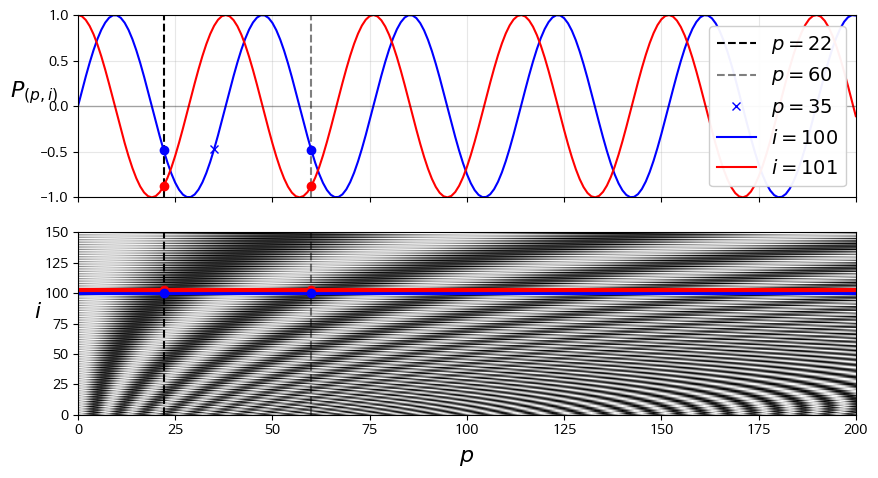

In [82]:
# 추가 코드 - 이 셀은 그림 16-9를 생성하고 저장합니다.
figure_max_length = 201
figure_embed_size = 512
pos_emb = PositionalEncoding(figure_max_length, figure_embed_size)
zeros = np.zeros((1, figure_max_length, figure_embed_size), np.float32)
P = pos_emb(zeros)[0].numpy()
i1, i2, crop_i = 100, 101, 150
p1, p2, p3 = 22, 60, 35
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(9, 5))
ax1.plot([p1, p1], [-1, 1], "k--", label="$p = {}$".format(p1))
ax1.plot([p2, p2], [-1, 1], "k--", label="$p = {}$".format(p2), alpha=0.5)
ax1.plot(p3, P[p3, i1], "bx", label="$p = {}$".format(p3))
ax1.plot(P[:,i1], "b-", label="$i = {}$".format(i1))
ax1.plot(P[:,i2], "r-", label="$i = {}$".format(i2))
ax1.plot([p1, p2], [P[p1, i1], P[p2, i1]], "bo")
ax1.plot([p1, p2], [P[p1, i2], P[p2, i2]], "ro")
ax1.legend(loc="center right", fontsize=14, framealpha=0.95)
ax1.set_ylabel("$P_{(p,i)}$", rotation=0, fontsize=16)
ax1.grid(True, alpha=0.3)
ax1.hlines(0, 0, figure_max_length - 1, color="k", linewidth=1, alpha=0.3)
ax1.axis([0, figure_max_length - 1, -1, 1])
ax2.imshow(P.T[:crop_i], cmap="gray", interpolation="bilinear", aspect="auto")
ax2.hlines(i1, 0, figure_max_length - 1, color="b", linewidth=3)
cheat = 2  # need to raise the red line a bit, or else it hides the blue one
ax2.hlines(i2+cheat, 0, figure_max_length - 1, color="r", linewidth=3)
ax2.plot([p1, p1], [0, crop_i], "k--")
ax2.plot([p2, p2], [0, crop_i], "k--", alpha=0.5)
ax2.plot([p1, p2], [i2+cheat, i2+cheat], "ro")
ax2.plot([p1, p2], [i1, i1], "bo")
ax2.axis([0, figure_max_length - 1, 0, crop_i])
ax2.set_xlabel("$p$", fontsize=16)
ax2.set_ylabel("$i$", rotation=0, fontsize=16)
save_fig("positional_embedding_plot")
plt.show()

### 멀티 헤드 어텐션

In [83]:
N = 2  # 원본 구조는 6
num_heads = 8
dropout_rate = 0.1
n_units = 128  # 피드 포워드 블록의 첫 번째 Dense 층의 유닛 개수
encoder_pad_mask = tf.math.not_equal(encoder_input_ids, 0)[:, tf.newaxis]
Z = encoder_in
for _ in range(N):
    skip = Z
    attn_layer = tf.keras.layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=embed_size, dropout=dropout_rate)
    Z = attn_layer(Z, value=Z, attention_mask=encoder_pad_mask)
    Z = tf.keras.layers.LayerNormalization()(tf.keras.layers.Add()([Z, skip]))
    skip = Z
    Z = tf.keras.layers.Dense(n_units, activation="relu")(Z)
    Z = tf.keras.layers.Dense(embed_size)(Z)
    Z = tf.keras.layers.Dropout(dropout_rate)(Z)
    Z = tf.keras.layers.LayerNormalization()(tf.keras.layers.Add()([Z, skip]))

In [84]:
decoder_pad_mask = tf.math.not_equal(decoder_input_ids, 0)[:, tf.newaxis]
causal_mask = tf.linalg.band_part(  # 하삼각행렬을 생성합니다.
    tf.ones((batch_max_len_dec, batch_max_len_dec), tf.bool), -1, 0)

In [85]:
encoder_outputs = Z  # 인코더의 최종 출력을 저장해 보겠습니다.
Z = decoder_in  # 디코더는 자체 입력으로 시작합니다.
for _ in range(N):
    skip = Z
    attn_layer = tf.keras.layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=embed_size, dropout=dropout_rate)
    Z = attn_layer(Z, value=Z, attention_mask=causal_mask & decoder_pad_mask)
    Z = tf.keras.layers.LayerNormalization()(tf.keras.layers.Add()([Z, skip]))
    skip = Z
    attn_layer = tf.keras.layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=embed_size, dropout=dropout_rate)
    Z = attn_layer(Z, value=encoder_outputs, attention_mask=encoder_pad_mask)
    Z = tf.keras.layers.LayerNormalization()(tf.keras.layers.Add()([Z, skip]))
    skip = Z
    Z = tf.keras.layers.Dense(n_units, activation="relu")(Z)
    Z = tf.keras.layers.Dense(embed_size)(Z)
    Z = tf.keras.layers.LayerNormalization()(tf.keras.layers.Add()([Z, skip]))

**경고**: 다음 셀을 실행하는 데 시간이 걸릴 수 있습니다(GPU를 사용하지 않는 경우 2~3시간 정도 소요될 수 있습니다).

In [86]:
Y_proba = tf.keras.layers.Dense(vocab_size, activation="softmax")(Z)
model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs],
                       outputs=[Y_proba])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
model.fit((X_train, X_train_dec), Y_train, epochs=10,
          validation_data=((X_valid, X_valid_dec), Y_valid))

Epoch 1/10
3125/3125 [==============================] - 225s 63ms/step - loss: 1.8388 - accuracy: 0.5988 - val_loss: 1.4028 - val_accuracy: 0.6636
Epoch 2/10
3125/3125 [==============================] - 187s 60ms/step - loss: 1.3411 - accuracy: 0.6735 - val_loss: 1.2936 - val_accuracy: 0.6854
Epoch 3/10
3125/3125 [==============================] - 175s 56ms/step - loss: 1.2371 - accuracy: 0.6932 - val_loss: 1.2046 - val_accuracy: 0.7057
Epoch 4/10
3125/3125 [==============================] - 176s 56ms/step - loss: 1.1725 - accuracy: 0.7051 - val_loss: 1.1706 - val_accuracy: 0.7106
Epoch 5/10
3125/3125 [==============================] - 175s 56ms/step - loss: 1.1248 - accuracy: 0.7144 - val_loss: 1.1387 - val_accuracy: 0.7181
Epoch 6/10
3125/3125 [==============================] - 175s 56ms/step - loss: 1.0870 - accuracy: 0.7210 - val_loss: 1.1092 - val_accuracy: 0.7222
Epoch 7/10
3125/3125 [==============================] - 185s 59ms/step - loss: 1.0567 - accuracy: 0.7272 - val_loss: 1

In [87]:
translate("I like soccer and also going to the beach")

1/1 [==============================] - 0s 27ms/step


'me gusta el fútbol y voy a la playa'

# 허깅 페이스

코랩에서 실행하는 경우 트랜스포머스 및 데이터셋 라이브러리를 설치합니다:

In [88]:
if "google.colab" in sys.modules:
    %pip install -q -U transformers
    %pip install -q -U datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 76.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 105.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 56.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.1 MB/s eta 0:00:00


In [89]:
from transformers import pipeline

classifier = pipeline("sentiment-analysis")  # 다른 많은 작업을 사용할 수 있습니다.
result = classifier("The actors were very convincing.")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


모델은 매우 편향적일 수 있습니다. 예를 들어, 훈련 데이터와 사용 방법에 따라 일부 국가를 좋아하거나 싫어할 수 있으므로 신중하게 사용하세요:

In [90]:
classifier(["I am from India.", "I am from Iraq."])

[{'label': 'POSITIVE', 'score': 0.9896161556243896},
 {'label': 'NEGATIVE', 'score': 0.9811071157455444}]

In [91]:
model_name = "huggingface/distilbert-base-uncased-finetuned-mnli"
classifier_mnli = pipeline("text-classification", model=model_name)
classifier_mnli("She loves me. [SEP] She loves me not.")

[{'label': 'contradiction', 'score': 0.9790191650390625}]

In [92]:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFAutoModelForSequenceClassification.from_pretrained(model_name)

Some layers from the model checkpoint at huggingface/distilbert-base-uncased-finetuned-mnli were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at huggingface/distilbert-base-uncased-finetuned-mnli and are newly initialized: ['dropout_21']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [93]:
token_ids = tokenizer(["I like soccer. [SEP] We all love soccer!",
                       "Joe lived for a very long time. [SEP] Joe is old."],
                      padding=True, return_tensors="tf")
token_ids

{'input_ids': <tf.Tensor: shape=(2, 15), dtype=int32, numpy=
array([[ 101, 1045, 2066, 4715, 1012,  102, 2057, 2035, 2293, 4715,  999,
         102,    0,    0,    0],
       [ 101, 3533, 2973, 2005, 1037, 2200, 2146, 2051, 1012,  102, 3533,
        2003, 2214, 1012,  102]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(2, 15), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=int32)>}

In [94]:
token_ids = tokenizer([("I like soccer.", "We all love soccer!"),
                       ("Joe lived for a very long time.", "Joe is old.")],
                      padding=True, return_tensors="tf")
token_ids

{'input_ids': <tf.Tensor: shape=(2, 15), dtype=int32, numpy=
array([[ 101, 1045, 2066, 4715, 1012,  102, 2057, 2035, 2293, 4715,  999,
         102,    0,    0,    0],
       [ 101, 3533, 2973, 2005, 1037, 2200, 2146, 2051, 1012,  102, 3533,
        2003, 2214, 1012,  102]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(2, 15), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=int32)>}

In [95]:
outputs = model(token_ids)
outputs

TFSequenceClassifierOutput(loss=None, logits=<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[-2.1123812 ,  1.178679  ,  1.4101001 ],
       [-0.01478288,  1.0962466 , -0.9919953 ]], dtype=float32)>, hidden_states=None, attentions=None)

In [96]:
Y_probas = tf.keras.activations.softmax(outputs.logits)
Y_probas

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.01619703, 0.43523598, 0.54856706],
       [0.22655995, 0.6881722 , 0.08526783]], dtype=float32)>

In [97]:
Y_pred = tf.argmax(Y_probas, axis=1)
Y_pred  # 0 = contradiction, 1 = entailment, 2 = neutral

<tf.Tensor: shape=(2,), dtype=int64, numpy=array([2, 1])>

In [98]:
sentences = [("Sky is blue", "Sky is red"), ("I love her", "She loves me")]
X_train = tokenizer(sentences, padding=True, return_tensors="tf").data
y_train = tf.constant([0, 2])  # contradiction, neutral
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(loss=loss, optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=2)

Epoch 1/2
1/1 [==============================] - 48s 48s/step - loss: 0.6666 - accuracy: 0.5000
Epoch 2/2
1/1 [==============================] - 0s 60ms/step - loss: 0.3430 - accuracy: 1.0000


# 연습문제 해답

## 1. to 7.

부록 A 참조.

## 8.
_연습문제: 호크라이터와 슈미트후버는 LSTM에 관한 [논문](https://homl.info/93)에서 임베딩된 레버 문법을 사용했습니다. 이는 ‘BPBTSXXVPSEPE’와 같은 문자열을 만드는 인공 문법입니다. 이 주제에 대한 제니 오어의 훌륭한 소개(https://homl.info/108)를 확인해보세요. 특정 임베딩된 레버 문법 하나를 선택하고(제니 오어의 페이지에 있는 것과 같은), 그다음에 문자열이 이 문법을 따르는지 아닌지 구별하는 RNN을 훈련해보세요. 먼저 문법에 맞는 문자열 50%와 그렇지 않은 문자열 50%를 담은 훈련 배치를 생성하는 함수를 만들어야 합니다._

먼저 문법에 맞는 문자열을 생성하는 함수가 필요합니다. 이 문법은 각 상태에서 가능한 전이 상태의 리스트입니다. 하나의 전이는 출력할 문자열(또는 생성할 문법)과 다음 상태를 지정합니다.

In [99]:
default_reber_grammar = [
    [("B", 1)],           # (state 0) =B=>(state 1)
    [("T", 2), ("P", 3)], # (state 1) =T=>(state 2) or =P=>(state 3)
    [("S", 2), ("X", 4)], # (state 2) =S=>(state 2) or =X=>(state 4)
    [("T", 3), ("V", 5)], # 등등 ...
    [("X", 3), ("S", 6)],
    [("P", 4), ("V", 6)],
    [("E", None)]]        # (state 6) =E=>(terminal state)

embedded_reber_grammar = [
    [("B", 1)],
    [("T", 2), ("P", 3)],
    [(default_reber_grammar, 4)],
    [(default_reber_grammar, 5)],
    [("T", 6)],
    [("P", 6)],
    [("E", None)]]

def generate_string(grammar):
    state = 0
    output = []
    while state is not None:
        index = np.random.randint(len(grammar[state]))
        production, state = grammar[state][index]
        if isinstance(production, list):
            production = generate_string(grammar=production)
        output.append(production)
    return "".join(output)

기본 레버 문법을 기반으로 몇 가지 문자열을 생성해 보겠습니다:

In [100]:
np.random.seed(42)

for _ in range(25):
    print(generate_string(default_reber_grammar), end=" ")

BTXXTTVPXTVPXTTVPSE BPVPSE BTXSE BPVVE BPVVE BTSXSE BPTVPXTTTVVE BPVVE BTXSE BTXXVPSE BPTTTTTTTTVVE BTXSE BPVPSE BTXSE BPTVPSE BTXXTVPSE BPVVE BPVVE BPVVE BPTTVVE BPVVE BPVVE BTXXVVE BTXXVVE BTXXVPXVVE 

좋아 보이네요. 이제 임베딩된 레버 문법을 기반으로 몇 가지 문자열을 생성해 보겠습니다:

In [101]:
np.random.seed(42)

for _ in range(25):
    print(generate_string(embedded_reber_grammar), end=" ")

BTBPTTTVPXTVPXTTVPSETE BPBPTVPSEPE BPBPVVEPE BPBPVPXVVEPE BPBTXXTTTTVVEPE BPBPVPSEPE BPBTXXVPSEPE BPBTSSSSSSSXSEPE BTBPVVETE BPBTXXVVEPE BPBTXXVPSEPE BTBTXXVVETE BPBPVVEPE BPBPVVEPE BPBTSXSEPE BPBPVVEPE BPBPTVPSEPE BPBTXXVVEPE BTBPTVPXVVETE BTBPVVETE BTBTSSSSSSSXXVVETE BPBTSSSXXTTTTVPSEPE BTBPTTVVETE BPBTXXTVVEPE BTBTXSETE 

좋네요, 이제 이 문법을 따르지 않는 문자열을 생성할 함수를 만듭니다. 무작위하게 문자열을 만들 수 있지만 그렇게 하면 너무 문제가 쉬워지므로 대신 문법을 따르는 문자열을 만든 후 하나의 문자만 바꾸어 놓도록 하겠습니다:

In [102]:
POSSIBLE_CHARS = "BEPSTVX"

def generate_corrupted_string(grammar, chars=POSSIBLE_CHARS):
    good_string = generate_string(grammar)
    index = np.random.randint(len(good_string))
    good_char = good_string[index]
    bad_char = np.random.choice(sorted(set(chars) - set(good_char)))
    return good_string[:index] + bad_char + good_string[index + 1:]

잘못된 문자열 몇 개를 만들어 보죠:

In [103]:
np.random.seed(42)

for _ in range(25):
    print(generate_corrupted_string(embedded_reber_grammar), end=" ")

BTBPTTTPPXTVPXTTVPSETE BPBTXEEPE BPBPTVVVEPE BPBTSSSSXSETE BPTTXSEPE BTBPVPXTTTTTTEVETE BPBTXXSVEPE BSBPTTVPSETE BPBXVVEPE BEBTXSETE BPBPVPSXPE BTBPVVVETE BPBTSXSETE BPBPTTTPTTTTTVPSEPE BTBTXXTTSTVPSETE BBBTXSETE BPBTPXSEPE BPBPVPXTTTTVPXTVPXVPXTTTVVEVE BTBXXXTVPSETE BEBTSSSSSXXVPXTVVETE BTBXTTVVETE BPBTXSTPE BTBTXXTTTVPSBTE BTBTXSETX BTBTSXSSTE 

문자열을 바로 RNN에 주입할 수는 없기 때문에 어떤 식으로든 인코딩해야 합니다. 한 가지 방법은 각 문자를 원-핫 인코딩하는 것입니다. 또 다른 방식은 임베딩을 사용하는 것입니다. 두 번째 방법을 사용해 보겠습니다(문자 개수가 작다면 원-핫 인코딩도 좋은 선택일 것입니다). 임베딩을 위해 각 문자열을 문자 ID의 시퀀스로 바꾸어야 합니다. 가능한 문자 "BEPSTVX"의 문자열 인덱스를 사용해 이런 작업을 수행하는 함수를 만들어 보겠습니다:

In [104]:
def string_to_ids(s, chars=POSSIBLE_CHARS):
    return [chars.index(c) for c in s]

In [105]:
string_to_ids("BTTTXXVVETE")

[0, 4, 4, 4, 6, 6, 5, 5, 1, 4, 1]

이제 50%는 올바른 문자열 50%는 잘못된 문자열로 이루어진 데이터셋을 만듭니다:

In [106]:
def generate_dataset(size):
    good_strings = [
        string_to_ids(generate_string(embedded_reber_grammar))
        for _ in range(size // 2)
    ]
    bad_strings = [
        string_to_ids(generate_corrupted_string(embedded_reber_grammar))
        for _ in range(size - size // 2)
    ]
    all_strings = good_strings + bad_strings
    X = tf.ragged.constant(all_strings, ragged_rank=1)
    y = np.array([[1.] for _ in range(len(good_strings))] +
                 [[0.] for _ in range(len(bad_strings))])
    return X, y

In [107]:
np.random.seed(42)

X_train, y_train = generate_dataset(10000)
X_valid, y_valid = generate_dataset(2000)

첫 번째 훈련 샘플을 확인해 보겠습니다:

In [108]:
X_train[0]

<tf.Tensor: shape=(22,), dtype=int32, numpy=
array([0, 4, 0, 2, 4, 4, 4, 5, 2, 6, 4, 5, 2, 6, 4, 4, 5, 2, 3, 1, 4, 1],
      dtype=int32)>

어떤 클래스에 속할까요?

In [109]:
y_train[0]

array([1.])

완벽합니다! 이제 올바른 문자열을 구분할 RNN을 만들 준비가 되었습니다. 간단한 시퀀스 이진 분류기를 만듭니다:

In [110]:
np.random.seed(42)
tf.random.set_seed(42)

embedding_size = 5

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=[None], dtype=tf.int32, ragged=True),
    tf.keras.layers.Embedding(input_dim=len(POSSIBLE_CHARS),
                              output_dim=embedding_size),
    tf.keras.layers.GRU(30),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
optimizer = tf.keras.optimizers.SGD(learning_rate=0.02, momentum = 0.95,
                                    nesterov=True)
model.compile(loss="binary_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
313/313 [==============================] - 6s 10ms/step - loss: 0.6888 - accuracy: 0.5351 - val_loss: 0.6774 - val_accuracy: 0.4805
Epoch 2/20
313/313 [==============================] - 4s 13ms/step - loss: 0.6630 - accuracy: 0.5665 - val_loss: 0.6589 - val_accuracy: 0.4960
Epoch 3/20
313/313 [==============================] - 2s 8ms/step - loss: 0.6472 - accuracy: 0.5904 - val_loss: 0.6473 - val_accuracy: 0.5615
Epoch 4/20
313/313 [==============================] - 2s 8ms/step - loss: 0.6301 - accuracy: 0.6083 - val_loss: 0.6375 - val_accuracy: 0.6190
Epoch 5/20
313/313 [==============================] - 2s 8ms/step - loss: 0.5689 - accuracy: 0.6828 - val_loss: 0.5264 - val_accuracy: 0.7450
Epoch 6/20
313/313 [==============================] - 2s 8ms/step - loss: 0.4899 - accuracy: 0.7544 - val_loss: 0.4457 - val_accuracy: 0.8165
Epoch 7/20
313/313 [==============================] - 4s 12ms/step - loss: 0.3436 - accuracy: 0.8618 - val_loss: 0.3240 - val_accuracy: 0.8750
Epo

이제 두 개의 까다로운 문자열로 이 RNN을 테스트해 보죠: 첫 번째는 잘못된 것이고 두 번째는 올바른 것입니다. 이 문자열은 마지막에서 두 번째 글자만 다릅니다. RNN이 이를 맞춘다면 두 번째 문자가 항상 끝에서 두 번째 문자와 같아야 한다는 패턴을 알게 됐다는 것을 의미합니다. 이렇게 하려면 꽤 긴 단기 기억(long short-term memory)이 필요합니다(그래서 GRU 셀을 사용했습니다).

In [111]:
test_strings = ["BPBTSSSSSSSXXTTVPXVPXTTTTTVVETE",
                "BPBTSSSSSSSXXTTVPXVPXTTTTTVVEPE"]
X_test = tf.ragged.constant([string_to_ids(s) for s in test_strings], ragged_rank=1)

y_proba = model.predict(X_test)
print()
print("레버 문자열일 추정 확률:")
for index, string in enumerate(test_strings):
    print("{}: {:.2f}%".format(string, 100 * y_proba[index][0]))

1/1 [==============================] - 0s 486ms/step

레버 문자열일 추정 확률:
BPBTSSSSSSSXXTTVPXVPXTTTTTVVETE: 0.03%
BPBTSSSSSSSXXTTVPXVPXTTTTTVVEPE: 99.69%


쨘! 잘 작동하네요. 이 RNN이 매우 높은 신뢰도로 정확한 답을 냈습니다. :)

## 9.
_연습문제: 날짜 문자열 포맷을 변환하는 인코더-디코더 모델을 훈련하세요(예를 들어, ‘April 22, 2019’에서 ‘2019-04-22’로 바꿉니다)._

먼저 데이터셋을 만들어 보죠. 1000-01-01 ~ 9999-12-31 사이의 랜덤한 날짜를 사용하겠습니다:

In [112]:
from datetime import date

# strftime()의 %B 포맷은 로케일에 의존하기 때문에 사용할 수 있습니다.
MONTHS = ["January", "February", "March", "April", "May", "June",
          "July", "August", "September", "October", "November", "December"]

def random_dates(n_dates):
    min_date = date(1000, 1, 1).toordinal()
    max_date = date(9999, 12, 31).toordinal()

    ordinals = np.random.randint(max_date - min_date, size=n_dates) + min_date
    dates = [date.fromordinal(ordinal) for ordinal in ordinals]

    x = [MONTHS[dt.month - 1] + " " + dt.strftime("%d, %Y") for dt in dates]
    y = [dt.isoformat() for dt in dates]
    return x, y

다음은 입력과 출력 형식에 맞춘 랜덤한 몇 개의 날짜입니다:

In [113]:
np.random.seed(42)

n_dates = 3
x_example, y_example = random_dates(n_dates)
print("{:25s}{:25s}".format("Input", "Target"))
print("-" * 50)
for idx in range(n_dates):
    print("{:25s}{:25s}".format(x_example[idx], y_example[idx]))

Input                    Target                   
--------------------------------------------------
September 20, 7075       7075-09-20               
May 15, 8579             8579-05-15               
January 11, 7103         7103-01-11               


입력 가능한 전체 문자를 나열해 보죠:

In [114]:
INPUT_CHARS = "".join(sorted(set("".join(MONTHS) + "0123456789, ")))
INPUT_CHARS

' ,0123456789ADFJMNOSabceghilmnoprstuvy'

그리고 다음은 출력 가능한 전체 문자입니다:

In [115]:
OUTPUT_CHARS = "0123456789-"

이전 연습문제에서처럼 문자열을 문자 ID 리스트로 바꾸는 함수를 작성해 보겠습니다:

In [116]:
def date_str_to_ids(date_str, chars=INPUT_CHARS):
    return [chars.index(c) for c in date_str]

In [117]:
date_str_to_ids(x_example[0], INPUT_CHARS)

[19, 23, 31, 34, 23, 28, 21, 23, 32, 0, 4, 2, 1, 0, 9, 2, 9, 7]

In [118]:
date_str_to_ids(y_example[0], OUTPUT_CHARS)

[7, 0, 7, 5, 10, 0, 9, 10, 2, 0]

In [119]:
def prepare_date_strs(date_strs, chars=INPUT_CHARS):
    X_ids = [date_str_to_ids(dt, chars) for dt in date_strs]
    X = tf.ragged.constant(X_ids, ragged_rank=1)
    return (X + 1).to_tensor() # 0을 패딩 토큰 ID로 사용

def create_dataset(n_dates):
    x, y = random_dates(n_dates)
    return prepare_date_strs(x, INPUT_CHARS), prepare_date_strs(y, OUTPUT_CHARS)

In [120]:
np.random.seed(42)

X_train, Y_train = create_dataset(10000)
X_valid, Y_valid = create_dataset(2000)
X_test, Y_test = create_dataset(2000)

In [121]:
Y_train[0]

<tf.Tensor: shape=(10,), dtype=int32, numpy=array([ 8,  1,  8,  6, 11,  1, 10, 11,  3,  1], dtype=int32)>

### 첫 번째 버전: 기본적인 seq2seq 모델

먼저 가장 간단한 모델을 시도해 보겠습니다: 입력 시퀀스가 먼저 (임베딩 층 뒤에 하나의 LSTM 층으로 구성된) 인코더를 통과하여 벡터로 출력됩니다. 그 다음 이 벡터가 (하나의 LSTM 층 뒤에 밀집 층으로 구성된) 디코더로 들어가 벡터의 시퀀스를 출력합니다. 각 벡터는 가능한 모든 출력 문자에 대한 추정 확률입니다.

디코더는 시퀀스를 입력으로 기대하기 때문에 가능한 가장 긴 출력 시퀀스만큼 (인코더의 출력) 벡터를 반복합니다.

In [122]:
embedding_size = 32
max_output_length = Y_train.shape[1]

np.random.seed(42)
tf.random.set_seed(42)

encoder = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=len(INPUT_CHARS) + 1,
                           output_dim=embedding_size,
                           input_shape=[None]),
    tf.keras.layers.LSTM(128)
])

decoder = tf.keras.Sequential([
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.Dense(len(OUTPUT_CHARS) + 1, activation="softmax")
])

model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.RepeatVector(max_output_length),
    decoder
])

optimizer = tf.keras.optimizers.Nadam()
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
313/313 [==============================] - 11s 20ms/step - loss: 1.6892 - accuracy: 0.3992 - val_loss: 1.2189 - val_accuracy: 0.5632
Epoch 2/20
313/313 [==============================] - 3s 10ms/step - loss: 1.2325 - accuracy: 0.5697 - val_loss: 1.0699 - val_accuracy: 0.6237
Epoch 3/20
313/313 [==============================] - 3s 11ms/step - loss: 0.8406 - accuracy: 0.6900 - val_loss: 0.7009 - val_accuracy: 0.7292
Epoch 4/20
313/313 [==============================] - 3s 10ms/step - loss: 0.5980 - accuracy: 0.7603 - val_loss: 0.5092 - val_accuracy: 0.7904
Epoch 5/20
313/313 [==============================] - 4s 14ms/step - loss: 0.4135 - accuracy: 0.8348 - val_loss: 0.3419 - val_accuracy: 0.8657
Epoch 6/20
313/313 [==============================] - 3s 10ms/step - loss: 0.2778 - accuracy: 0.8982 - val_loss: 0.2149 - val_accuracy: 0.9294
Epoch 7/20
313/313 [==============================] - 3s 10ms/step - loss: 0.1545 - accuracy: 0.9578 - val_loss: 0.1125 - val_accuracy: 0.975

좋아 보이네요, 100% 검증 정확도를 달성했습니다! 이 모델을 사용해 예측을 만들어 보죠. 문자 ID 시퀀스를 문자열로 바꾸는 함수를 작성하겠습니다:

In [123]:
def ids_to_date_strs(ids, chars=OUTPUT_CHARS):
    return ["".join([("?" + chars)[index] for index in sequence])
            for sequence in ids]

이제 모델을 사용해 샘플 날짜를 변환합니다.

In [124]:
X_new = prepare_date_strs(["September 17, 2009", "July 14, 1789"])

In [125]:
ids = model.predict(X_new).argmax(axis=-1)
for date_str in ids_to_date_strs(ids):
    print(date_str)

1/1 [==============================] - 1s 1s/step
2009-09-17
1789-07-14


완벽합니다! :)

하지만 (가장 긴 날짜에 해당하는) 길이가 18인 입력 문자열에서만 모델이 훈련되었기 때문에 짧은 시퀀스에서는 잘 동작하지 않습니다:

In [126]:
X_new = prepare_date_strs(["May 02, 2020", "July 14, 1789"])

In [127]:
ids = model.predict(X_new).argmax(axis=-1)
for date_str in ids_to_date_strs(ids):
    print(date_str)

1/1 [==============================] - 1s 737ms/step
2020-01-02
1789-09-14


이런! 패딩을 사용해 훈련할 때와 동일한 길이의 시퀀스를 전달해야 할 것 같습니다. 이를 위해 헬퍼 함수를 작성해 보죠:

In [128]:
max_input_length = X_train.shape[1]

def prepare_date_strs_padded(date_strs):
    X = prepare_date_strs(date_strs)
    if X.shape[1] < max_input_length:
        X = tf.pad(X, [[0, 0], [0, max_input_length - X.shape[1]]])
    return X

def convert_date_strs(date_strs):
    X = prepare_date_strs_padded(date_strs)
    ids = model.predict(X).argmax(axis=-1)
    return ids_to_date_strs(ids)

In [129]:
convert_date_strs(["May 02, 2020", "July 14, 1789"])

1/1 [==============================] - 0s 23ms/step


['2020-05-02', '1789-07-14']

좋네요! 물론 더 쉽게 날짜 변환 도구를 만들 수 있습니다(예를 들면, 정규식이나 더 단순한 문자열 조작). 하지만 신경망을 사용하는 것이 더 멋져 보이네요. ;-)

하지만 실제 시퀀스-투-시퀀스 문제는 더 어렵습니다. 완벽함을 추구하기 위해 더 강력한 모델을 만들어 보겠습니다.

### 두 번째 버전: 디코더에서 한 타임 스텝 이동된 타깃 주입하기(티처 포싱(teacher forcing))

디코더에세 인코더 출력 벡터를 단순히 반복한 것을 주입하는 대신 한 타임 스텝 오른쪽으로 이동된 타깃 시퀀스를 주입할 수 있습니다. 이렇게 하면 각 타임 스텝에서 디코더는 이전 타깃 문자가 무엇인지 알게 됩니다. 이는 더 복잡한 시퀀스-투-시퀀스 문제를 다루는데 도움이 됩니다.

각 타깃 시퀀스의 첫 번째 출력 문자는 이전 문자가 없기 때문에 시퀀스 시작(start-of-sequence, sos)을 나타내는 새로운 토큰이 필요합니다.

추론에서는 타깃을 알지 못하므로 디코더에게 무엇을 주입해야 할까요? sos 토큰을 시작해서 한 번에 하나의 문자를 예측하고 디코더에게 지금까지 예측한 모든 문자를 주입할 수 있습니다(나중에 이 노트북에서 더 자세히 알아 보겠습니다).

하지만 디코더의 LSTM이 스텝마다 이전 타깃을 입력으로 기대한다면 인코더의 벡터 출력을 어떻게 전달할까요? 한가지 방법은 출력 벡터를 무시하는 것입니다. 그리고 대신 인코더의 LSTM 상태를 디코더의 LSTM의 초기 상태로 사용합니다(이렇게 하려면 인코더의 LSTM과 디코더의 LSTM 유닛 개수가 같아야 합니다).

그럼 (훈련, 검증, 테스트를 위한) 디코더의 입력을 만들어 보죠. sos 토큰은 가능한 출력 문자의 마지막 ID + 1으로 나타냅니다.

In [130]:
sos_id = len(OUTPUT_CHARS) + 1

def shifted_output_sequences(Y):
    sos_tokens = tf.fill(dims=(len(Y), 1), value=sos_id)
    return tf.concat([sos_tokens, Y[:, :-1]], axis=1)

X_train_decoder = shifted_output_sequences(Y_train)
X_valid_decoder = shifted_output_sequences(Y_valid)
X_test_decoder = shifted_output_sequences(Y_test)

디코더의 훈련 입력을 확인해 보죠:

In [131]:
X_train_decoder

<tf.Tensor: shape=(10000, 10), dtype=int32, numpy=
array([[12,  8,  1, ..., 10, 11,  3],
       [12,  9,  6, ...,  6, 11,  2],
       [12,  8,  2, ...,  2, 11,  2],
       ...,
       [12, 10,  8, ...,  2, 11,  4],
       [12,  2,  2, ...,  3, 11,  3],
       [12,  8,  9, ...,  8, 11,  3]], dtype=int32)>

이제 모델을 만듭니다. 이제 더 이상 간단한 시퀀셜 모델이 아니므로 함수형 API를 사용하겠습니다:

In [132]:
encoder_embedding_size = 32
decoder_embedding_size = 32
lstm_units = 128

np.random.seed(42)
tf.random.set_seed(42)

encoder_input = tf.keras.layers.Input(shape=[None], dtype=tf.int32)
encoder_embedding = tf.keras.layers.Embedding(
    input_dim=len(INPUT_CHARS) + 1,
    output_dim=encoder_embedding_size)(encoder_input)
_, encoder_state_h, encoder_state_c = tf.keras.layers.LSTM(
    lstm_units, return_state=True)(encoder_embedding)
encoder_state = [encoder_state_h, encoder_state_c]

decoder_input = tf.keras.layers.Input(shape=[None], dtype=tf.int32)
decoder_embedding = tf.keras.layers.Embedding(
    input_dim=len(OUTPUT_CHARS) + 2,
    output_dim=decoder_embedding_size)(decoder_input)
decoder_lstm_output = tf.keras.layers.LSTM(lstm_units, return_sequences=True)(
    decoder_embedding, initial_state=encoder_state)
decoder_output = tf.keras.layers.Dense(len(OUTPUT_CHARS) + 1,
                                    activation="softmax")(decoder_lstm_output)

model = tf.keras.Model(inputs=[encoder_input, decoder_input],
                           outputs=[decoder_output])

optimizer = tf.keras.optimizers.Nadam()
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit([X_train, X_train_decoder], Y_train, epochs=10,
                    validation_data=([X_valid, X_valid_decoder], Y_valid))

Epoch 1/10
313/313 [==============================] - 11s 18ms/step - loss: 1.6308 - accuracy: 0.3862 - val_loss: 1.3434 - val_accuracy: 0.4890
Epoch 2/10
313/313 [==============================] - 4s 12ms/step - loss: 1.1673 - accuracy: 0.5669 - val_loss: 0.9584 - val_accuracy: 0.6450
Epoch 3/10
313/313 [==============================] - 3s 11ms/step - loss: 0.7778 - accuracy: 0.7225 - val_loss: 0.6256 - val_accuracy: 0.7752
Epoch 4/10
313/313 [==============================] - 3s 10ms/step - loss: 0.4397 - accuracy: 0.8555 - val_loss: 0.2771 - val_accuracy: 0.9229
Epoch 5/10
313/313 [==============================] - 4s 14ms/step - loss: 0.1917 - accuracy: 0.9562 - val_loss: 0.1189 - val_accuracy: 0.9815
Epoch 6/10
313/313 [==============================] - 4s 12ms/step - loss: 0.0807 - accuracy: 0.9912 - val_loss: 0.0603 - val_accuracy: 0.9942
Epoch 7/10
313/313 [==============================] - 3s 10ms/step - loss: 0.0766 - accuracy: 0.9893 - val_loss: 0.2957 - val_accuracy: 0.904

이 모델도 100% 검증 정확도를 달성했지만 더 빠릅니다.

이 모델을 사용해 몇 가지 예측을 수행해 보죠. 이번에는 한 문자씩 예측해야 합니다.

In [133]:
sos_id = len(OUTPUT_CHARS) + 1

def predict_date_strs(date_strs):
    X = prepare_date_strs_padded(date_strs)
    Y_pred = tf.fill(dims=(len(X), 1), value=sos_id)
    for index in range(max_output_length):
        pad_size = max_output_length - Y_pred.shape[1]
        X_decoder = tf.pad(Y_pred, [[0, 0], [0, pad_size]])
        Y_probas_next = model.predict([X, X_decoder])[:, index:index+1]
        Y_pred_next = tf.argmax(Y_probas_next, axis=-1, output_type=tf.int32)
        Y_pred = tf.concat([Y_pred, Y_pred_next], axis=1)
    return ids_to_date_strs(Y_pred[:, 1:])

In [134]:
predict_date_strs(["July 14, 1789", "May 01, 2020"])

1/1 [==============================] - 0s 22ms/step


['1789-07-14', '2020-05-01']

잘 동작하네요! 다음으로 트랜스포머 버전을 만들어 보세요. :)

## 10.
_문제: 케라스 웹사이트에 있는 "Natural language image search with a Dual Encoder"(https://homl.info/dualtuto) 예제를 살펴보세요. 동일한 임베딩 공간 내에서 이미지와 텍스트를 모두 표현할 수 있는 모델을 만드는 방법을 배우게 됩니다. 이렇게 하면 OpenAI의 [CLIP 모델](https://openai.com/blog/clip/)에서와 같이 텍스트 프롬프트를 사용하여 이미지를 검색할 수 있습니다._

링크를 클릭하고 안내를 따르기만 하면 됩니다.

## 11.
_문제: 허깅 페이스의 트랜스포머스 라이브러리를 사용하여 텍스트를 생성할 수 있는 사전 훈련된 언어 모델(예, GPT)을 다운로드하고 보다 설득력 있는 셰익스피어식 텍스트를 생성해 보세요. 모델의 `generate()` 메서드를 사용해야 합니다. 자세한 내용은 허깅 페이스 온라인 문서를 참조하세요._

먼저 사전 훈련된 모델을 로드해 보겠습니다. 이 예제에서는 추가 언어 모델(입력 임베딩에 가중치가 연결된 선형 층)을 위에 얹은 OpenAI의 GPT 모델을 사용합니다. 임포트하고 사전 훈련된 가중치를 로드해 보겠습니다(이렇게 하면 약 445MB의 데이터가 `~/.cache/torch/transformers`로 다운로드됩니다):

In [135]:
from transformers import TFOpenAIGPTLMHeadModel

model = TFOpenAIGPTLMHeadModel.from_pretrained("openai-gpt")

All model checkpoint layers were used when initializing TFOpenAIGPTLMHeadModel.

All the layers of TFOpenAIGPTLMHeadModel were initialized from the model checkpoint at openai-gpt.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFOpenAIGPTLMHeadModel for predictions without further training.


다음으로 이 모델에 특화된 토크나이저가 필요합니다. 만약 설치되어 있으면 [spaCy](https://spacy.io/) 및 [ftfy](https://pypi.org/project/ftfy/) 라이브러리를 사용하려고 시도하고, 그렇지 않으면 BERT의 `BasicTokenizer`와 바이트 쌍 인코딩(대부분의 사용 사례에 적합할 것입니다)을 사용합니다:

In [136]:
from transformers import OpenAIGPTTokenizer

tokenizer = OpenAIGPTTokenizer.from_pretrained("openai-gpt")

ftfy or spacy is not installed using BERT BasicTokenizer instead of SpaCy & ftfy.


이제 토크나이저를 사용하여 프롬프트 텍스트를 토큰화 및 인코딩해 보겠습니다:

In [137]:
tokenizer("hello everyone")

{'input_ids': [3570, 1473], 'attention_mask': [1, 1]}

In [138]:
prompt_text = "This royal throne of kings, this sceptred isle"
encoded_prompt = tokenizer.encode(prompt_text,
                                  add_special_tokens=False,
                                  return_tensors="tf")
encoded_prompt

<tf.Tensor: shape=(1, 10), dtype=int32, numpy=
array([[  616,  5751,  6404,   498,  9606,   240,   616, 26271,  7428,
        16187]], dtype=int32)>

쉬워요! 다음으로 모델을 사용하여 프롬프트 뒤를 이은 텍스트를 생성해 보겠습니다. 프롬프트 텍스트로 시작하여 각각 5개의 다른 문장을 40개의 토큰 안에서 생성합니다. 모든 하이퍼파라미터의 기능에 대한 설명은 패트릭 폰 플라텐(Hugging Face)의 [블로그 게시물](https://huggingface.co/blog/how-to-generate)을 참조하세요. 하이퍼파라미터를 사용해 더 나은 결과를 얻을 수 있습니다.

In [139]:
num_sequences = 5
length = 40

generated_sequences = model.generate(
    input_ids=encoded_prompt,
    do_sample=True,
    max_length=length + len(encoded_prompt[0]),
    temperature=1.0,
    top_k=0,
    top_p=0.9,
    repetition_penalty=1.0,
    num_return_sequences=num_sequences,
)

generated_sequences

<tf.Tensor: shape=(5, 50), dtype=int32, numpy=
array([[  616,  5751,  6404,   498,  9606,   240,   616, 26271,  7428,
        16187, 40477,   544,   246, 15147,   562,   481,  9606,   498,
          481,  2868,   239, 40477,   620,   481,  5908,   498,   481,
         2868,   240,   556,   531,  2892,   945,   488,   524,   929,
         2784,   240,   498,  6228, 17379,   240, 40477,  9447,   485,
          524,  5353,  7339,   556,   524],
       [  616,  5751,  6404,   498,  9606,   240,   616, 26271,  7428,
        16187,   246,  1436,   239,   606,  1683,   793,   504,   246,
         6404,   498,  9753, 14386,   239,   606,  1259,  1683,   557,
        11907,   498,   616,   989,   239,   244, 40477,   664,   566,
          558,  7380, 28252,   481,   618,   240,   488,   664,   566,
         7380,  2071,   551,   498,  1300],
       [  616,  5751,  6404,   498,  9606,   240,   616, 26271,  7428,
        16187,   267, 40477,  1598,   481,  4187,   498,  1504,   260,
        34885

이제 생성된 시퀀스를 디코딩하고 인쇄해 보겠습니다:

In [140]:
for sequence in generated_sequences:
    text = tokenizer.decode(sequence, clean_up_tokenization_spaces=True)
    print(text)
    print("-" * 80)

this royal throne of kings, this sceptred isle 
 is a beacon for the kings of the ages. 
 so the hero of the ages, with an older son and his first mate, of stolen runes, 
 returns to his former kingdom with his
--------------------------------------------------------------------------------
this royal throne of kings, this sceptred isle a god. we sit here on a throne of blessed harmony. we must sit as ruler of this people. " 
 no one had dared contradict the king, and no one dared speak out of turn
--------------------------------------------------------------------------------
this royal throne of kings, this sceptred isle! 
 may the gods of ah - puch's balance still hold the power of this - tent - white flesh upon his body, may you be a light of power in the great heat and heat of
--------------------------------------------------------------------------------
this royal throne of kings, this sceptred isle. 
 in his choice, the king was given the kingship of house gidedrian, a three 

언어 모델이 위에 있는 변형을 포함하여 트랜스포머 라이브러리에서 사전 학습된 모델로 사용할 수 있는 GPT-2, CTRL, Transformer-XL 또는 XLNet과 같은 최신(및 더 큰) 모델을 사용해 볼 수 있습니다. 전처리 단계는 모델마다 조금씩 다르므로 트랜스포머 문서에서 이 [생성 예제](https://github.com/huggingface/transformers/blob/master/examples/run_generation.py)를 확인하시기 바랍니다(이 예제에서는 파이토치를 사용하지만 모델 클래스 이름 앞에 `TF`를 추가하고, `.to()` 메서드 호출을 제거하고, `"pt"` 대신 `return_tensors="tf"`를 사용하는 등 약간의 조정만 하면 작동합니다).

이 챕터가 재미있으셨기를 바랍니다! :)